In [125]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.io as io
import os
import json

class TrainVideoDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.video_files = [f for f in os.listdir(root_dir) if f.endswith('.mp4')]
        with open(root_dir+"\metadata.json", 'r') as file :
            self.data= json.load(file)

    def __len__(self):
        return len(self.video_files)
    
    def __getitem__(self, idx):
        video_path = os.path.join(self.root_dir, self.video_files[idx])
        video, audio, info = io.read_video(video_path, pts_unit='sec')

        return video.permute(0,3,1,2), self.data[self.video_files[idx]]['label']
    

    
dataset=TrainVideoDataset('deepfake-detection\dfdc_train_part_1')

FAKE
torch.Size([299, 3, 1080, 1920])


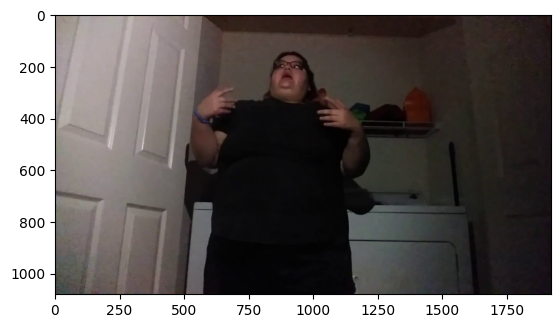

In [128]:
import matplotlib.pyplot as plt

def print_img(img) :
    img=img.permute(1,2,0)
    plt.imshow(img)

video, label = dataset[0]
img=video[0]

print_img(img)
print(label)

print(video.shape)

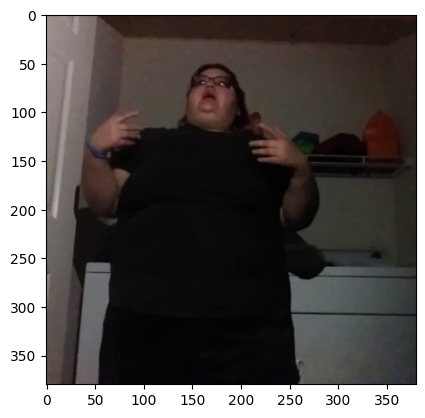

In [130]:
from PIL import Image
import torchvision.transforms.functional as TF

def resize_image(image, new_height, new_width, y=0, x=0, h=None, w=None):
    # 


    H,W=image.shape[1:]
    
    if h==None :
        h=H-y
    if w==None :
        w=W-x

    top=y
    bottom=y+h
    left=x
    right=x+w

    padding=False

    if y+h>H or x+w>W :
        hh=min(y+h,H)
        ww=min(x+w,W)
        zeros=torch.zeros(3,h,w).int()
        zeros[:, 0:(hh-y), 0:(ww-x)]=image[:, y:hh, x:ww]
        #print_img(zeros)
        padding=True

    scale=h/w
    new_scale=new_height/new_width

    if scale != new_scale :
        cH=int(w*new_scale)
        cW= int(h/new_scale)
        if cH<h :
            diff=h-cH
            top=int(min(y+diff//2,y+h-diff//2))
            bottom=int(max(y+diff//2,y+h-diff//2))
        else :
            diff=w-cW
            left=int(min(x+diff//2,x+w-diff//2))
            right=int(max(x+diff//2,x+w-diff//2))
    
    # Perform resizing
    if padding :
        cropped_image = TF.resize(zeros[:, (top-y):(bottom-y), (left-x):(right-x)], [new_height, new_width])
    else :
        cropped_image = TF.resize(image[:, (top-y):(bottom-y), (left-x):(right-x)], [new_height, new_width])
    return cropped_image

#exemple

video, label = dataset[0]
img=video[0]


img=resize_image(img, 380, 380)
print_img(img)


Modèle

In [ ]:
class DeepfakeDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense=nn.Linear(380*380,1)
        self.flat=nn.Flatten()
        
    def forward(self, x):
        y=self.flat(x)
        y=self.dense(y)
        return y

Boucle d'entraînement

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.MSELoss(reduction='none')
model = DeepfakeDetector().to(device)

batch_size=10

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for i in range(len(dataset)):
    
    optimizer.zero_grad()
    video, label=dataset[i]
    if label=='FAKE' :
        label=1
    else :
        label=0
    l=video.shape[0]
    X=video[[i*(l//(batch_size-1)) for i in range(10)]]
    
    for j in range(batch_size) :
        
    X = X.to(device)
    label = label.to(device)
    label_pred = model(X)
    loss = loss_fn(label, label_pred)
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print(f"Loss {loss.item():.4f}")

Boucle de test

In [ ]:
#npy, np.save


class TestVideoDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.video_files = [f for f in os.listdir(root_dir) if f.endswith('.mp4')]
        with open(root_dir+"\metadata.json", 'r') as file :
            self.data= json.load(file)

    def __len__(self):
        return len(self.video_files)
    
    def __getitem__(self, idx):
        video_path = os.path.join(self.root_dir, self.video_files[idx])
        video, audio, info = io.read_video(video_path, pts_unit='sec')

        return video.permute(0,3,1,2), self.data[self.video_files[idx]]['label']